# Disaster Tweets

Competition: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)

References:

1. [Disaster Tweet Classification using BERT & Neural Network](https://www.analyticsvidhya.com/blog/2021/12/disaster-tweet-classification-using-bert-neural-network/) - Analytics Vidhya.
2. [Handling imbalanced dataset in Machine Learning](https://www.youtube.com/watch?v=JnlM4yLFNuo) – YouTube.
3. [What is the Difference Between Test and Validation Datasets?](https://machinelearningmastery.com/difference-test-validation-datasets/) - Machine Learning Mastery.
4. [Natural Language Processing: Cleaning up Tweets](https://medium.com/codex/natural-language-processing-cleaning-up-tweets-2b71793e91b5) - Medium.
5. [Use Early Stopping to Halt the Training of Neural Networks At the Right Time](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) - Machine Learning Mastery.
6. [How to split data into three sets (train, validation, and test) And why?](https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c) - Towards Data Science.
7. [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) - TensorFlow.
8. [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) - TensorFlow.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

os.environ['AUTOGRAPH_VERBOSITY'] = '0'
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Data Prep

- /kaggle/input/nlp-getting-started/sample_submission.csv
- /kaggle/input/nlp-getting-started/train.csv
- /kaggle/input/nlp-getting-started/test.csv

In [2]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

train_data.sample(n=10, random_state=23)

,id,keyword,location,text,target
1461,2109,catastrophe,NaN,.@robdelaney Catastrophe is anything but! I literally have been unable to stop ejaculating.,1
1837,2642,crashed,too far,He was only .4 of a second faster than me and I overtook him twice (then crashed) tru luv &lt;3 &lt;3,0
6144,8763,siren,NaN,Internet firms to be subject to new cybersecurity rules in EU... http://t.co/lafTJ2GyLY,0
2354,3389,demolition,"ÌÏT: 36.142163,-95.979189",@samajp32 really needs to tone it down some in the weight room. RT @SoonerSportsTV: Demolition (cont) http://t.co/2o7Eva1cOe,0
4765,6781,lightning,Elchilicitanierraversal,#NowPlaying 'The Lightning Strike' de Snow Patrol de A Hundred Million Suns ? http://t.co/GrzcHkDF37,0
6882,9866,traumatised,cork,@AnnmarieRonan @niamhosullivanx I can't watch tat show its like a horror movie to me I get flashbacks an everything #traumatised,0
3566,5097,famine,NaN,when things become terrible more than the great Ethiopian famine...,0
1847,2657,crush,NaN,'@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ??,1
4961,7071,meltdown,"Colorado, USA",@nprfreshair I really can't believe he is skipping out before the Republican meltdown...I mean 'debate'.,0
7021,10064,typhoon,"Ibadan,Oyo state",Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG,1


In [3]:
sample_sentence = train_data.iloc[[7021]].text.to_string(header=False, index=False)
sample_sentence

'Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/UsVyHdG9OG'

In [4]:
#df = train_data.drop(['id','keyword','location'],axis=1)
df = train_data.drop(['id'],axis=1)
df.sample(10, random_state=23)

# Is the dataset is balanced: count of both class labels (0 and 1):

df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Optional undersampling step

In [5]:
if True:
    df_0_class = df[df['target']==0]
    df_1_class = df[df['target']==1]
    df_0_class_undersampled = df_0_class.sample(df_1_class.shape[0])
    df = pd.concat([df_0_class_undersampled, df_1_class], axis=0)

    df['target'].value_counts()

### Process Tweets

In [6]:
!pip install contractions

import contractions, emoji, re, unidecode

from nltk.stem import PorterStemmer

class TweetSweeper:
    def __init__(self, tweets):
        self.tweets = tweets
        # Tweet Text
        self.stemmer = PorterStemmer()
        self.tweets['text_clean'] = self.tweets['text'].apply(lambda x: contractions.fix(x))
        self.tweets['text_clean'] = self.tweets['text_clean'].apply(lambda x: self.demojize(x))
        self.tweets['hashtags'] = self.tweets['text'].apply(lambda x: [x for x in x.split(" ") if x.startswith("#")])
        # Keyword
        self.tweets['keyword'] = self.tweets['keyword'].apply(str)
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.clean_keywords(x))
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.remove_accents(x))
        self.tweets['keyword'] = self.tweets['keyword'].apply(lambda x: self.remove_punctuation(x))
        self.tweets['stems'] = self.tweets['keyword'].apply(lambda x: self.stemmer.stem(x))
        # Location
        self.tweets['location'] = self.tweets['location'].apply(str)
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_accents(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_punctuation(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_extra_w_space(x))
        self.tweets['location'] = self.tweets['location'].apply(lambda x: self.remove_nums(x))
        
        # Counts
        self.tweets['emojis'] = self.tweets['text'].apply(self.emoji_count)
        self.tweets['num_hashtags'] = self.tweets['text'].apply(self.hash_count)
        self.tweets['token_count'] = self.tweets['text'].apply(lambda x: len(x))
        
    def demojize(self, tweet):
        emojis = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags = re.UNICODE)
        cleaned_text = emojis.sub(r'', tweet)
        return cleaned_text
    
    def emoji_count(self, tweet):
        tweet = emoji.demojize(tweet, delimiters=('__','__'))
        pattern = r'_+[a-z_&]+_+'
        return len(re.findall(pattern, tweet))
    
    def hash_count(self, string):
        words = string.split()
        hashtags = [word for word in words if word.startswith('#')]
        return len(hashtags)
    
    def clean_keywords(self, keyword):
        cleaned = re.sub(r'%20', ' ', keyword)
        return cleaned
    
    def remove_accents(self, keyword):
        cleaned = unidecode.unidecode(keyword)
        return cleaned
    
    def remove_punctuation(self, keyword):
        cleaned = re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]"," ",keyword)
        return cleaned
    
    def remove_nums(self, location):
        cleaned = re.sub(r'\d+', '', location)
        return cleaned

    def remove_extra_w_space(self, location):
        cleaned_text = re.sub(r"\s+"," ", location).strip()
        return cleaned_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 10.8 MB/s eta 0:00:00


Process the tweets now ..

In [7]:
sweep_data = TweetSweeper(train_data).tweets.copy()
sweep_data.head()

,id,keyword,location,text,target,text_clean,hashtags,stems,emojis,num_hashtags,token_count
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,[#earthquake],nan,0,1,69
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,[],nan,0,0,38
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,[],nan,0,0,133
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California",[#wildfires],nan,0,1,65
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,"[#Alaska, #wildfires]",nan,0,2,88


In [8]:
# Do we really see difference?
sweep_data[['text', 'text_clean']][sweep_data['text'] != sweep_data['text_clean']].head(10)

,text,text_clean
7,I'm on top of the hill and I can see a fire in the woods...,I am on top of the hill and I can see a fire in the woods...
8,There's an emergency evacuation happening now in the building across the street,There is an emergency evacuation happening now in the building across the street
9,I'm afraid that the tornado is coming to our area...,I am afraid that the tornado is coming to our area...
11,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding,Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GOING TO DO WHAT AM I GOING TO DO FVCK #flooding
12,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count,#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I have lost count
15,What's up man?,What is up man?
25,No way...I can't eat that shit,No way...I cannot eat that shit
36,@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.,@PhDSquares #mufc they have built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.
41,on the outside you're ablaze and alive\nbut you're dead inside,on the outside you are ablaze and alive\nbut you are dead inside
49,First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.,First night with retainers in. It is quite weird. Better get used to it; I have to wear them every single night for the next year at least.


### Feature Engineering

Create a utility function that converts each training, validation, and test set DataFrame into a **tf.data.Dataset**, then shuffles and batches the data.

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [10]:
batch_size = 5 # just for limited investigation

# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
sweep_data.dtypes
sweep_data['keyword'] = sweep_data['keyword'].apply(str)
sweep_data['location'] = sweep_data['location'].apply(str)
# TODO: Failed to convert a NumPy array to a Tensor (Unsupported object type list).
sweep_data['hashtags'] = sweep_data['hashtags'].apply(str)

train_ds = df_to_dataset(sweep_data, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of keyword:', train_features['keyword'])
print('A batch of targets:', label_batch )

Every feature: ['id', 'keyword', 'location', 'text', 'target', 'text_clean', 'hashtags', 'stems', 'emojis', 'num_hashtags', 'token_count']
A batch of keyword: tf.Tensor(
[[b'devastation']
 [b'thunder']
 [b'bloody']
 [b'harm']
 [b'suicide bombing']], shape=(5, 1), dtype=string)
A batch of targets: tf.Tensor([1 0 0 0 1], shape=(5,), dtype=int64)


#### Numerical columns

In [11]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [12]:
token_count_col = train_features['token_count']
layer = get_normalization_layer('token_count', train_ds)
layer(token_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 1.0054314],
       [-1.4813154],
       [ 1.2718686],
       [ 1.153452 ],
       [ 0.916619 ]], dtype=float32)>

#### Categorical columns

In [13]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

In [14]:
# using `stems` as categorical for testing
test_stems_col = train_features['stems']
test_stems_layer = get_category_encoding_layer(name='stems',
                                               dataset=train_ds,
                                               dtype='string')
test_stems_layer(test_stems_col)

<tf.Tensor: shape=(5, 168), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## BERT Preprocessor & Encoder

In [15]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [16]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-768_A-12'

print(map_model_to_preprocess[bert_model_name])
print(map_name_to_handle[bert_model_name])

https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1


### Build Classification Model

Using the **Keras Functional API**:

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

In [17]:
def build_classifier_model(bert_model_name, train=train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features
    for header in ['token_count', 'num_hashtags']:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)
    
    # Categorical features
    for header in ['stems']:
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
        encoding_layer = get_category_encoding_layer(name=header,
                                                     dataset=train,
                                                     dtype='string',
                                                     max_tokens=100)
        encoded_categorical_col = encoding_layer(categorical_col)
        all_inputs.append(categorical_col)
        encoded_features.append(encoded_categorical_col)
    
    # BERT Text
    text_col = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_clean')
    bert_preprocess = hub.KerasLayer(map_model_to_preprocess[bert_model_name], name='preprocessing')
    encoder_inputs = bert_preprocess(text_col)
    
    bert_encoder = hub.KerasLayer(map_name_to_handle[bert_model_name], trainable=True, name='BERT_encoder')
    encoded_text_col = bert_encoder(encoder_inputs)
    all_inputs.append(text_col)
    encoded_features.append(encoded_text_col['pooled_output'])
    
    # Concat layers
    all_features = tf.keras.layers.concatenate(encoded_features)
    dense = tf.keras.layers.Dense(32, activation='relu', name='dense')(all_features)
    dropout = tf.keras.layers.Dropout(0.5, name='dropout')(dense)
    
    # final output layer has N neurons that makes it: 1) N=1 multi-label 2) N>1 multi-class problem.
    # "Binary is 0 or 1. You only need one node to represent 0 or 1"
    # "The number of nodes in your final layer should be equal to the number of classes you'd like to predict."
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(dropout) # sigmoid: binary activation output
    
    model = tf.keras.Model(all_inputs, output)
    
    #Refer to the SO thread Changing Keras Model from Binary Classification to Multi-classification for more details.
    # https://stackoverflow.com/questions/62903698/changing-keras-model-from-binary-classification-to-multi-classification
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    metrics = [
        tf.keras.metrics.BinaryAccuracy()
    ]
    
    model.compile(optimizer='adam', loss=loss, metrics=metrics)
    return model

model = build_classifier_model(bert_model_name)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stems (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text_clean (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 token_count (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 num_hashtags (InputLayer)      [(None, 1)]          0           []                               
                                                                                              

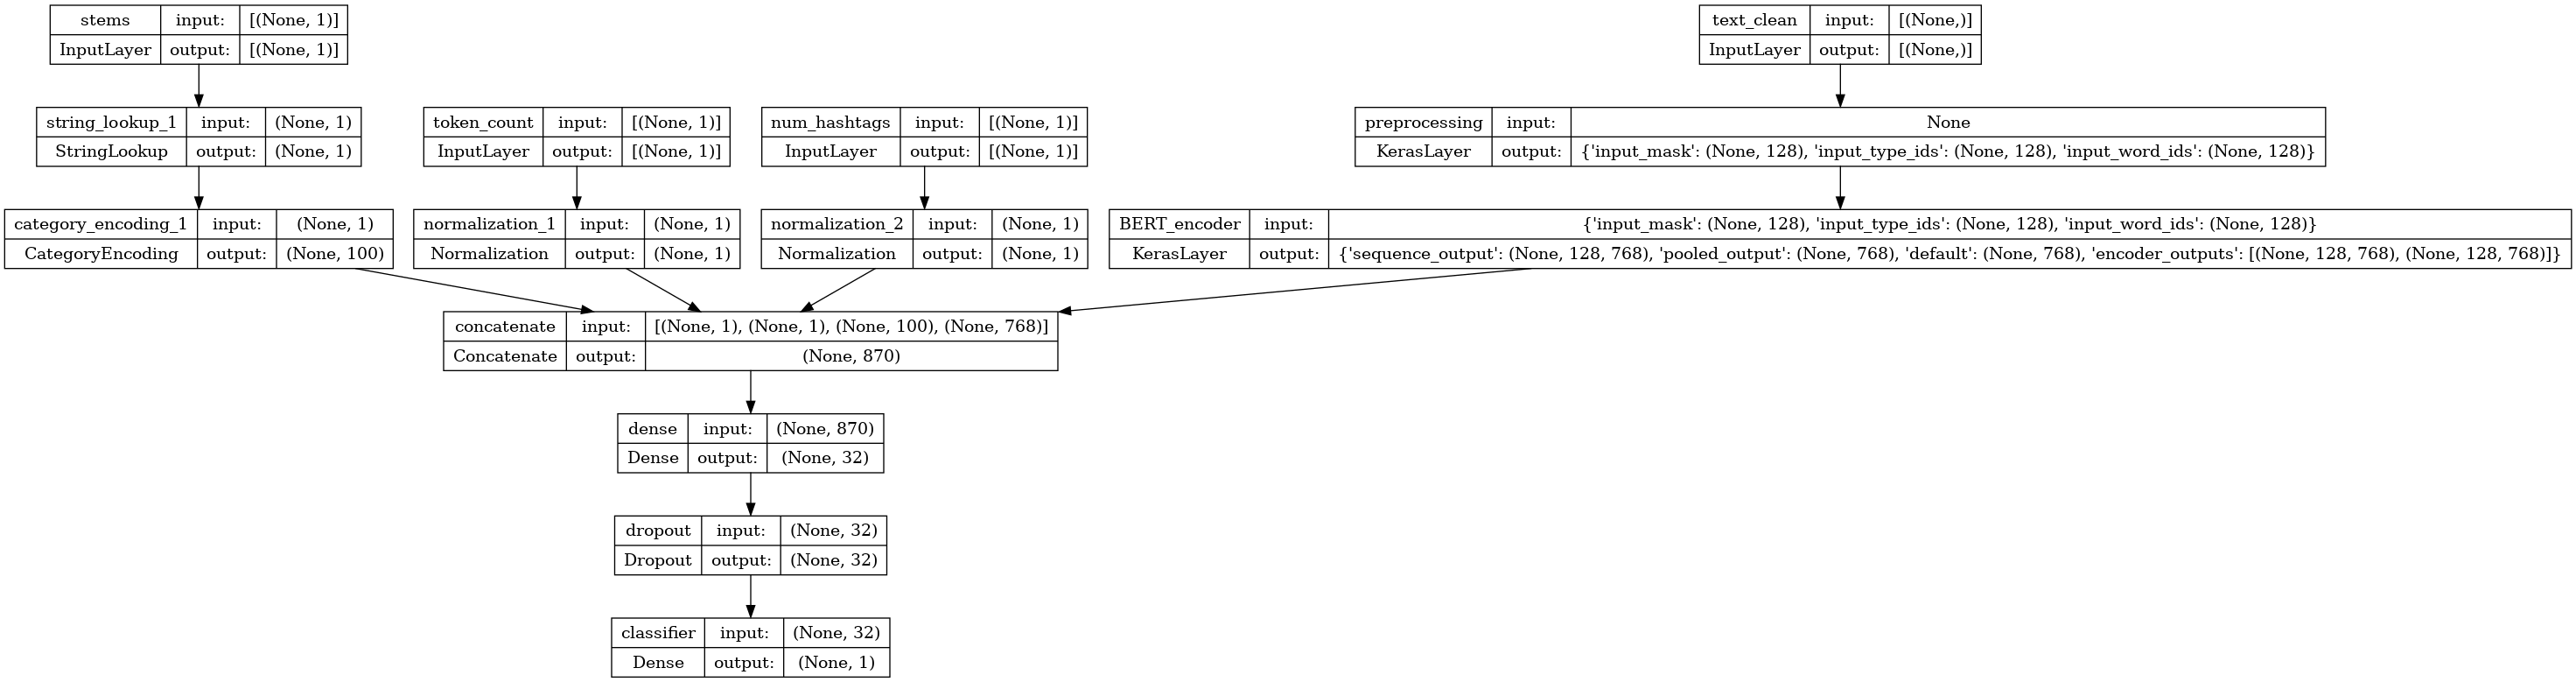

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True) #, rankdir="LR")

## Model Training

In [19]:
#feature_cols = ['token_count', 'stems', 'text_clean']

## Stratify important: Using SKLearn
#X_train, X_test, y_train, y_test = train_test_split(sweep_data[feature_cols], sweep_data['target'], test_size=0.1, stratify=sweep_data['target'], random_state=1) # 0.9 train, 0.1 test
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1) # 0.15 x 0.9 = 0.135 val

#train_df = pd.concat([X_train, y_train], axis=1)
#val_df = pd.concat([X_val, y_val], axis=1)
#test_df = pd.concat([X_test, y_test], axis=1)

# Tensorflow: For now, override the ValueError
train_df, val_df, test_df = np.split(sweep_data.sample(frac=1), [int(0.8*len(sweep_data)), int(0.9*len(sweep_data))])

batch_size = 256

# ResourceExhaustedError: Graph execution error:
# failed to allocate memory
# 	 [[{{node transformer/layer_1/activation/Gelu/Pow}}]]
# batch_size = 512

train_ds = df_to_dataset(train_df, batch_size=batch_size)
val_ds = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

print(len(train_df), 'training examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples')

6090 training examples
761 validation examples
762 test examples


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

model = build_classifier_model(bert_model_name, train_ds)
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])

Epoch 1/100
24/24 [==============================] - 100s 4s/step - loss: 0.6431 - binary_accuracy: 0.6475 - val_loss: 0.5356 - val_binary_accuracy: 0.7280
Epoch 2/100
24/24 [==============================] - 83s 3s/step - loss: 0.4603 - binary_accuracy: 0.8113 - val_loss: 0.5562 - val_binary_accuracy: 0.7819
Epoch 3/100
24/24 [==============================] - 84s 4s/step - loss: 0.2791 - binary_accuracy: 0.8934 - val_loss: 0.6047 - val_binary_accuracy: 0.7700
Epoch 4/100
24/24 [==============================] - 83s 3s/step - loss: 0.1678 - binary_accuracy: 0.9360 - val_loss: 0.7699 - val_binary_accuracy: 0.7503
Epoch 5/100
24/24 [==============================] - 86s 4s/step - loss: 0.1160 - binary_accuracy: 0.9642 - val_loss: 0.9439 - val_binary_accuracy: 0.7543
Epoch 6/100
24/24 [==============================] - 84s 4s/step - loss: 0.1004 - binary_accuracy: 0.9675 - val_loss: 1.1455 - val_binary_accuracy: 0.7635
Epoch 6: early stopping


In [21]:
loss, binary_acc = model.evaluate(test_ds, verbose=0)

print('Accuracy: %.3f' % (binary_acc))

Accuracy: 0.765


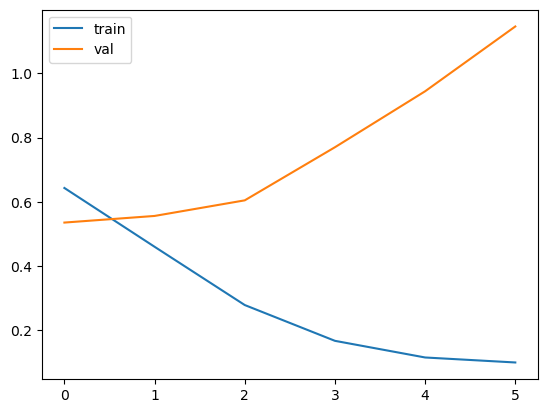

In [22]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Classification Report

A confusion matrix and classification report is a very statistically neat way to understand the performance of your model and take decisions accordingly, in case any improvement is required.

**Note:** Evaluate the final model on the "test" split.Evaluate the final model on the "test" split.

3/3 [==============================] - 9s 3s/step


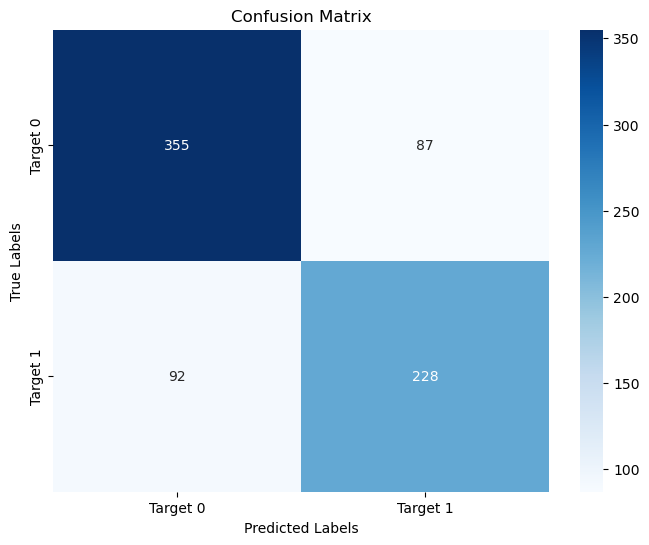

In [23]:
y_predicted = model.predict(test_ds)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

y_test = tf.concat([y for x, y in test_ds], axis=0)

matrix = confusion_matrix(y_predicted, y_test)

def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
class_labels = ['Target 0', 'Target 1']
plot_confusion_matrix(matrix, class_labels)

In [24]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       447
           1       0.71      0.72      0.72       315

    accuracy                           0.77       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



We used f1_score to validate our results, this is a competition requirement.

In [25]:
auc_roc = roc_auc_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

print(f'ROC-AUC: {auc_roc:.1%}')
print(f'f1: {f1:.1%}')

ROC-AUC: 75.9%
f1: 71.8%


## Submission

In [26]:
submission_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv', index_col='id')

sweep_submission = TweetSweeper(submission_data).tweets.copy()
sweep_submission['target'] = 0 # pop 'target'
sweep_submission['keyword'] = sweep_submission['keyword'].apply(str)
sweep_submission['location'] = sweep_submission['location'].apply(str)
# TODO: Failed to convert a NumPy array to a Tensor (Unsupported object type list).
sweep_submission['hashtags'] = sweep_submission['hashtags'].apply(str)

submission_ds = df_to_dataset(sweep_submission, shuffle=False, batch_size=batch_size)

submission = model.predict(submission_ds)
submission = submission.flatten()

submission_predicted = np.where(submission > 0.5, 1, 0)
submission_data['target'] = submission_predicted.tolist()
submission_data.reset_index(inplace=True)

submission_data = submission_data[['id', 'target']]
submission_data.head()

13/13 [==============================] - 35s 3s/step


,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [27]:
submission_data.to_csv('submission.csv', index= False)

!head -5 submission.csv

id,target
0,0
2,1
3,1
9,1
